In [182]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
from collections import Counter 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier,RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from joblib import dump, load
from sklearn import tree
import numpy as np
import itertools
import pickle

# Importing DataSet

In [183]:
train = pd.read_csv("/Users/aditya_mac/Downloads/IR2021_Project_38-main/Data/COVID/newtrain.csv",delimiter = '\t')
val = pd.read_csv("/Users/aditya_mac/Downloads/IR2021_Project_38-main/Data/COVID/newval.csv",delimiter = '\t')
test = pd.read_csv("/Users/aditya_mac/Downloads/IR2021_Project_38-main/Data/COVID/newtest.csv",delimiter = '\t')
entiredata = pd.concat([train,test,val],ignore_index=True)

# Exploratory Data Analysis

In [184]:
print("Train Label Counts:-")
print(train['label'].value_counts())
print("Total :",train['label'].shape[0])
print("\nValidation Label Counts:-")
print(val['label'].value_counts())
print("Total :",val['label'].shape[0])
print("\nTest Label Counts:-")
print(test['label'].value_counts())
print("Total :",test['label'].shape[0])

Train Label Counts:-
opinion    3805
real       3360
fake       3060
Name: label, dtype: int64
Total : 10225

Validation Label Counts:-
opinion    1269
real       1120
fake       1020
Name: label, dtype: int64
Total : 3409

Test Label Counts:-
opinion    1268
real       1120
fake       1020
Name: label, dtype: int64
Total : 3408


In [185]:
def CharacterAvg(data):
    ans = 0
    for i in data:
        ans += len(i)
    ans = ans/len(data)
    return ans

def WordAvg(data):
    ansx = 0
    for k in data:
        ansx += len(k.split())
    ansx = ansx/len(data)
    return ansx

def WordCloudMaker(mytext):
    stopwords_x = set(STOPWORDS)
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords_x, 
                min_font_size = 10).generate(mytext) 
                       
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

stops = set(stopwords.words("english"))
# stops.add("opinion")
# stops.add("#covid19")

def cleantext(string):
    text = string.lower().split()
    text = " ".join(text)
    text = text.replace('&amp',' ')
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)  
    text = text.replace('#covid19','')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.replace("opinion",'')
    text = text.split()
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [186]:
alltweets = entiredata['tweet']
allfake = entiredata[entiredata['label']=='fake']['tweet']
allreal = entiredata[entiredata['label']=='real']['tweet']
allopinion = entiredata[entiredata['label']=='opinion']['tweet']

In [187]:
mylist = [alltweets,allfake,allreal,allopinion]
mylistnames = ["All Tweets","Fake Tweets","Real Tweets","Opinion Tweets"]

for i in range(0,4):
    print(mylistnames[i])
    print("Average Character/Post For " + mylistnames[i] + " :",CharacterAvg(mylist[i]))
    print("Average Words/Post For " + mylistnames[i] + " :",WordAvg(mylist[i]),"\n")

All Tweets
Average Character/Post For All Tweets : 199.210656026288
Average Words/Post For All Tweets : 29.084966553221452 

Fake Tweets
Average Character/Post For Fake Tweets : 143.21058823529413
Average Words/Post For Fake Tweets : 21.652941176470588 

Real Tweets
Average Character/Post For Real Tweets : 217.12410714285716
Average Words/Post For Real Tweets : 31.9675 

Opinion Tweets
Average Character/Post For Opinion Tweets : 228.42620624408704
Average Words/Post For Opinion Tweets : 32.51624093345948 



In [188]:
combine_alltweets = " ".join(alltweets.map(lambda x : cleantext(x)))
combine_faketweets = " ".join(allfake.map(lambda x : cleantext(x)))
combine_realtweets = " ".join(allreal.map(lambda x : cleantext(x)))
combine_opiniontweets = " ".join(allopinion.map(lambda x : cleantext(x)))

Word Cloud for All Tweets


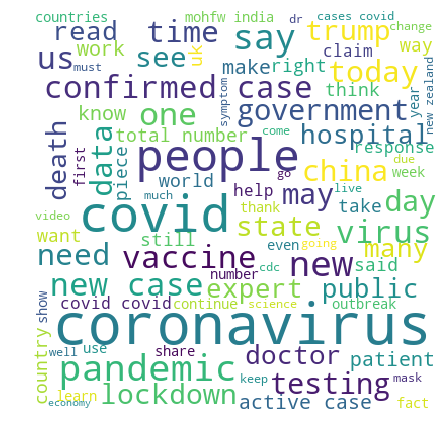

In [8]:
print("Word Cloud for All Tweets")
WordCloudMaker(combine_alltweets)

Word Cloud for Fake Tweets


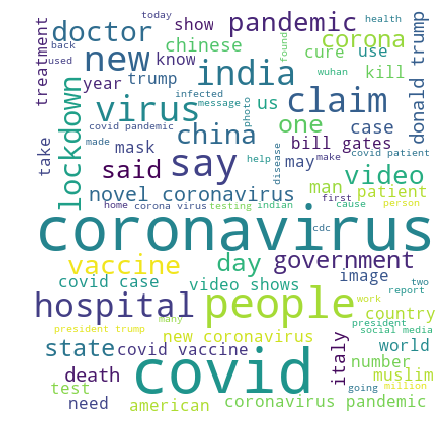

In [9]:
print("Word Cloud for Fake Tweets")
WordCloudMaker(combine_faketweets)

Word Cloud for Real Tweets


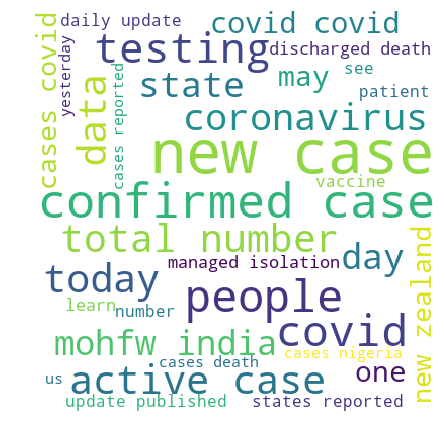

In [10]:
print("Word Cloud for Real Tweets")
WordCloudMaker(combine_realtweets)

Word Cloud for Opinion Tweets


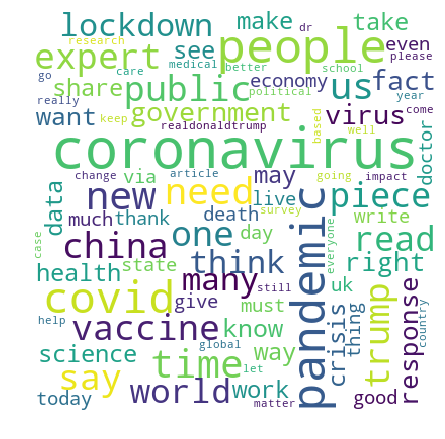

In [11]:
print("Word Cloud for Opinion Tweets")
WordCloudMaker(combine_opiniontweets)

In [32]:
# Identical to the code we are refrencing

print(len(set(combine_alltweets.split())))
print(len(set(combine_faketweets.split())))
print(len(set(combine_realtweets.split())))
print(len(set(combine_opiniontweets.split())))

# all_tokens_words = [w for w in combine_alltweets.split() if w not in stopwords]
# fake_tokens_words = [w for w in combine_faketweets.split() if w not in stopwords]
# real_tokens_words = [w for w in combine_realtweets.split() if w not in stopwords]
# opinion_tokens_words = [w for w in combine_opiniontweets.split() if w not in stopwords]

# Counter(all_tokens_words).most_common(20)
# Counter(fake_tokens_words).most_common(20)
# Counter(real_tokens_words).most_common(20)
# Counter(opinion_tokens_words).most_common(20)

32909
11941
10780
22816


# Model Application

In [189]:
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
test['tweet'] = test['tweet'].map(lambda x: cleantext(x))

In [190]:
def print_metrices(pred,true):
    print("Confusion Matrix is:-\n", confusion_matrix(true,pred))
    print("\n",classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true, average = 'weighted'))
    print("F1 : ",f1_score(pred,true, average = 'weighted'))

In [191]:
def savemodel(modelx,filename):
    filename = filename + '.sav'
    pickle.dump(modelx, open(filename, 'wb'))

In [192]:
def plot_confusionM(cf):
    import seaborn as sns
    categories = ['fake', 'opinion', 'real']
    sns.heatmap(cf,annot=True,fmt='',cmap='Blues',xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [193]:
acc_list = {}
precision_list = {}
recall_list = {}
f1_list = {}

In [194]:
def run_model(mymodel,name):
    pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('c', mymodel)])
    fit = pipeline.fit(train['tweet'],train['label'])
    print("Running on model " + name + ", the results are as follows:-\n")

#     pred = pipeline.predict(val['tweet'])
#     print_metrices(pred,val['label'])
    
#     plot_confusionM(confusion_matrix(val['label'],pred))
    
    # For Test set we have :-
    
    savemodel(pipeline,name)
    
    pred_test = pipeline.predict(test['tweet'])
    print_metrices(pred_test,test['label'])
    
    plot_confusionM(confusion_matrix(test['label'],pred_test))
    
    acc_list[name] = (accuracy_score(pred_test,test['label']))
    precision_list[name] = (precision_score(pred_test,test['label'], average = 'weighted'))
    recall_list[name] = (recall_score(pred_test,test['label'], average = 'weighted'))
    f1_list[name] = (f1_score(pred_test,test['label'], average = 'weighted'))
    
    # from sklearn.metrics import plot_confusion_matrix
    # plot_confusion_matrix(pipeline, val['tweet'],val['label'])
    # return pred

Running on model SVM, the results are as follows:-

Confusion Matrix is:-
 [[ 866  109   45]
 [ 116 1090   62]
 [  54   67  999]]

               precision    recall  f1-score   support

        fake       0.84      0.85      0.84      1020
     opinion       0.86      0.86      0.86      1268
        real       0.90      0.89      0.90      1120

   micro avg       0.87      0.87      0.87      3408
   macro avg       0.87      0.87      0.87      3408
weighted avg       0.87      0.87      0.87      3408

Accuracy :  0.8670774647887324
Precison :  0.8668948271195077
Recall :  0.8670774647887324
F1 :  0.8669589145604157


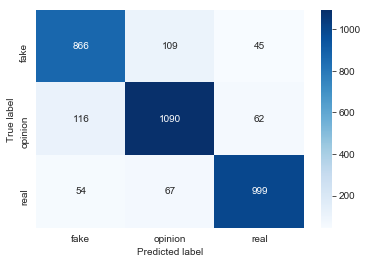

In [195]:
run_model(LinearSVC(random_state = 123),"SVM")

Running on model LogisticRegression, the results are as follows:-

Confusion Matrix is:-
 [[ 822  151   47]
 [  95 1120   53]
 [  69   96  955]]

               precision    recall  f1-score   support

        fake       0.83      0.81      0.82      1020
     opinion       0.82      0.88      0.85      1268
        real       0.91      0.85      0.88      1120

   micro avg       0.85      0.85      0.85      3408
   macro avg       0.85      0.85      0.85      3408
weighted avg       0.85      0.85      0.85      3408

Accuracy :  0.8500586854460094
Precison :  0.8514145210709578
Recall :  0.8500586854460094
F1 :  0.8499434457511147


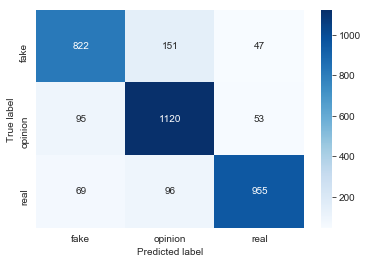

In [196]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
run_model(LogisticRegression(random_state = 123),"LogisticRegression")

Running on model GradientBoostingClassifier, the results are as follows:-

Confusion Matrix is:-
 [[ 727  233   60]
 [ 152 1050   66]
 [ 108  172  840]]

               precision    recall  f1-score   support

        fake       0.74      0.71      0.72      1020
     opinion       0.72      0.83      0.77      1268
        real       0.87      0.75      0.81      1120

   micro avg       0.77      0.77      0.77      3408
   macro avg       0.78      0.76      0.77      3408
weighted avg       0.77      0.77      0.77      3408

Accuracy :  0.7678990610328639
Precison :  0.7725438877621514
Recall :  0.7678990610328639
F1 :  0.7673535458188138


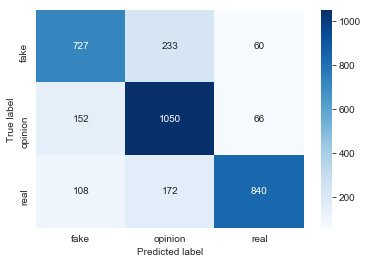

In [197]:
run_model(GradientBoostingClassifier(random_state = 123),"GradientBoostingClassifier")

Running on model DecisionTreeClassifier, the results are as follows:-

Confusion Matrix is:-
 [[764 151 105]
 [246 855 167]
 [122  96 902]]

               precision    recall  f1-score   support

        fake       0.67      0.75      0.71      1020
     opinion       0.78      0.67      0.72      1268
        real       0.77      0.81      0.79      1120

   micro avg       0.74      0.74      0.74      3408
   macro avg       0.74      0.74      0.74      3408
weighted avg       0.74      0.74      0.74      3408

Accuracy :  0.7397300469483568
Precison :  0.7442627069062693
Recall :  0.7397300469483568
F1 :  0.7400553952474427


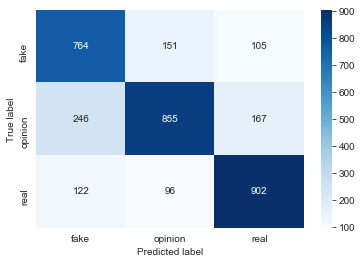

In [198]:
run_model(DecisionTreeClassifier(random_state = 123),"DecisionTreeClassifier")

## Extra Models

Running on model MLPClassifier, the results are as follows:-

Confusion Matrix is:-
 [[ 846  110   64]
 [ 133 1063   72]
 [  54   58 1008]]

               precision    recall  f1-score   support

        fake       0.82      0.83      0.82      1020
     opinion       0.86      0.84      0.85      1268
        real       0.88      0.90      0.89      1120

   micro avg       0.86      0.86      0.86      3408
   macro avg       0.85      0.86      0.86      3408
weighted avg       0.86      0.86      0.86      3408

Accuracy :  0.8559272300469484
Precison :  0.8563275276232145
Recall :  0.8559272300469484
F1 :  0.8560163894863768


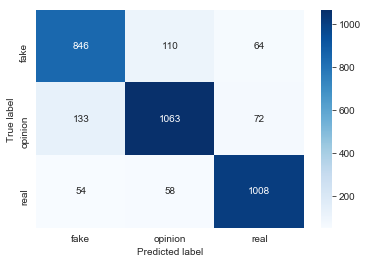

In [199]:
run_model(MLPClassifier(random_state = 123),"MLPClassifier")

Running on model AdaBoostClassifier, the results are as follows:-

Confusion Matrix is:-
 [[649 251 120]
 [215 931 122]
 [ 96 171 853]]

               precision    recall  f1-score   support

        fake       0.68      0.64      0.66      1020
     opinion       0.69      0.73      0.71      1268
        real       0.78      0.76      0.77      1120

   micro avg       0.71      0.71      0.71      3408
   macro avg       0.71      0.71      0.71      3408
weighted avg       0.71      0.71      0.71      3408

Accuracy :  0.7139084507042254
Precison :  0.7154321176156182
Recall :  0.7139084507042254
F1 :  0.7141720857927363


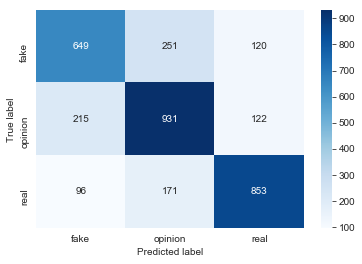

In [200]:
run_model(AdaBoostClassifier(random_state = 123),"AdaBoostClassifier")

Running on model RidgeClassifier, the results are as follows:-

Confusion Matrix is:-
 [[ 865  115   40]
 [ 104 1108   56]
 [  58   74  988]]

               precision    recall  f1-score   support

        fake       0.84      0.85      0.85      1020
     opinion       0.85      0.87      0.86      1268
        real       0.91      0.88      0.90      1120

   micro avg       0.87      0.87      0.87      3408
   macro avg       0.87      0.87      0.87      3408
weighted avg       0.87      0.87      0.87      3408

Accuracy :  0.8688380281690141
Precison :  0.8686971319421861
Recall :  0.8688380281690141
F1 :  0.8686464647243463


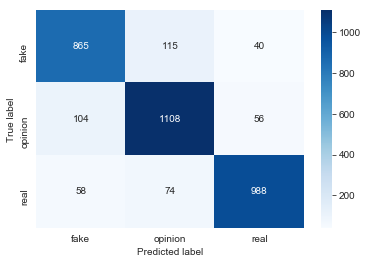

In [201]:
run_model(RidgeClassifier(random_state = 123),"RidgeClassifier")

Running on model RandomForestClassifier, the results are as follows:-

Confusion Matrix is:-
 [[842 122  56]
 [228 957  83]
 [129 101 890]]

               precision    recall  f1-score   support

        fake       0.70      0.83      0.76      1020
     opinion       0.81      0.75      0.78      1268
        real       0.86      0.79      0.83      1120

   micro avg       0.79      0.79      0.79      3408
   macro avg       0.79      0.79      0.79      3408
weighted avg       0.80      0.79      0.79      3408

Accuracy :  0.7890258215962441
Precison :  0.7916765966292694
Recall :  0.7890258215962441
F1 :  0.7878029134679824


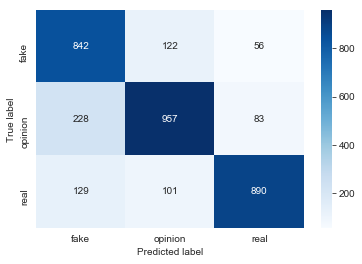

In [202]:
run_model(RandomForestClassifier(random_state = 123),"RandomForestClassifier")

Running on model BaggingClassifier, the results are as follows:-

Confusion Matrix is:-
 [[810 127  83]
 [238 923 107]
 [130  90 900]]

               precision    recall  f1-score   support

        fake       0.69      0.79      0.74      1020
     opinion       0.81      0.73      0.77      1268
        real       0.83      0.80      0.81      1120

   micro avg       0.77      0.77      0.77      3408
   macro avg       0.77      0.78      0.77      3408
weighted avg       0.78      0.77      0.77      3408

Accuracy :  0.772593896713615
Precison :  0.7749970492373427
Recall :  0.772593896713615
F1 :  0.7716975769357113


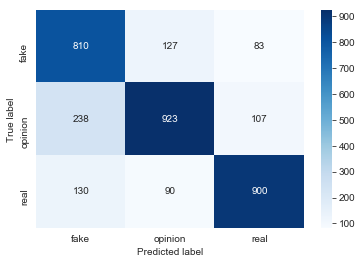

In [203]:
run_model(BaggingClassifier(random_state = 123),"BaggingClassifier")

Running on model KNeighborsClassifier, the results are as follows:-

Confusion Matrix is:-
 [[889  58  73]
 [429 722 117]
 [120  42 958]]

               precision    recall  f1-score   support

        fake       0.62      0.87      0.72      1020
     opinion       0.88      0.57      0.69      1268
        real       0.83      0.86      0.84      1120

   micro avg       0.75      0.75      0.75      3408
   macro avg       0.78      0.77      0.75      3408
weighted avg       0.79      0.75      0.75      3408

Accuracy :  0.7538145539906104
Precison :  0.7932256469737373
Recall :  0.7538145539906104
F1 :  0.7564363462099258


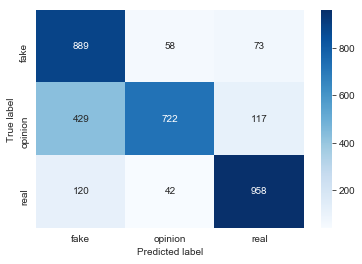

In [204]:
run_model(KNeighborsClassifier(),"KNeighborsClassifier")

Running on model SGDClassifier, the results are as follows:-

Confusion Matrix is:-
 [[ 866  118   36]
 [ 110 1102   56]
 [  62   71  987]]

               precision    recall  f1-score   support

        fake       0.83      0.85      0.84      1020
     opinion       0.85      0.87      0.86      1268
        real       0.91      0.88      0.90      1120

   micro avg       0.87      0.87      0.87      3408
   macro avg       0.87      0.87      0.87      3408
weighted avg       0.87      0.87      0.87      3408

Accuracy :  0.8670774647887324
Precison :  0.866825135543343
Recall :  0.8670774647887324
F1 :  0.8668064960726715


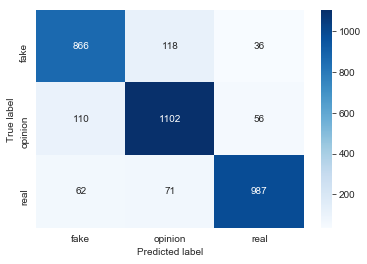

In [205]:
run_model(SGDClassifier(random_state = 123),"SGDClassifier")

In [206]:
print(acc_list,"\n")
print(precision_list,"\n")
print(recall_list,"\n")
print(f1_list,"\n")

{'SVM': 0.8670774647887324, 'LogisticRegression': 0.8500586854460094, 'GradientBoostingClassifier': 0.7678990610328639, 'DecisionTreeClassifier': 0.7397300469483568, 'MLPClassifier': 0.8559272300469484, 'AdaBoostClassifier': 0.7139084507042254, 'RidgeClassifier': 0.8688380281690141, 'RandomForestClassifier': 0.7890258215962441, 'BaggingClassifier': 0.772593896713615, 'KNeighborsClassifier': 0.7538145539906104, 'SGDClassifier': 0.8670774647887324} 

{'SVM': 0.8668948271195077, 'LogisticRegression': 0.8514145210709578, 'GradientBoostingClassifier': 0.7725438877621514, 'DecisionTreeClassifier': 0.7442627069062693, 'MLPClassifier': 0.8563275276232145, 'AdaBoostClassifier': 0.7154321176156182, 'RidgeClassifier': 0.8686971319421861, 'RandomForestClassifier': 0.7916765966292694, 'BaggingClassifier': 0.7749970492373427, 'KNeighborsClassifier': 0.7932256469737373, 'SGDClassifier': 0.866825135543343} 

{'SVM': 0.8670774647887324, 'LogisticRegression': 0.8500586854460094, 'GradientBoostingClassif

[]

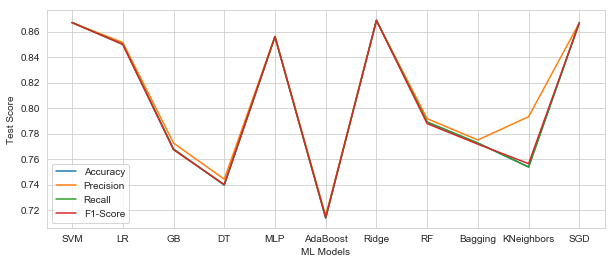

In [207]:
names = ["SVM","LR","GB","DT","MLP","AdaBoost","Ridge","RF","Bagging","KNeighbors","SGD"]
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10,4))
sns.lineplot(x = names,y = list(acc_list.values()),label = "Accuracy")
sns.lineplot(x = names,y = list(precision_list.values()),label = "Precision")
sns.lineplot(x = names,y = list(recall_list.values()),label = "Recall")
sns.lineplot(x = names,y = list(f1_list.values()),label = "F1-Score")
plt.xlabel('ML Models')
plt.ylabel('Test Score')
plt.legend()
plt.plot()

In [215]:
myfile = pd.read_csv("/Users/aditya_mac/Downloads/IR2021_Project_38-main/Data/COVID/newtest.csv",delimiter = '\t')

In [216]:
"""To load and show results of a model, dataset is the data you want to run the model on and modelfile is the
   pathname of the saved model file."""

def load_and_showresult(modelfile,dataset):
    dataset['tweet'] = dataset['tweet'].map(lambda x: cleantext(x))
    loadx_model = pickle.load(open(modelfile, 'rb'))
    
    predictions = loadx_model.predict(dataset['tweet'])
    print_metrices(predictions,dataset['label'])
    plot_confusionM(confusion_matrix(dataset['label'],predictions))

In [218]:
# load_and_showresult("/Users/aditya_mac/MLPClassifier.sav",myfile)

# Rough Work

In [208]:
# cc = pd.concat([val['tweet'],pd.Series(pred), val["label"]], axis = 1)
# def tester(test_tweet,cc):
#     dfx = pd.DataFrame(data = cc)
#     dfx.columns = ["Tweet","Prediction","RealData"]
#     print(cleantext(test_tweet))
#     print(pipeline.predict(pd.Series(cleantext(test_tweet))))

In [209]:
# print(dfx['Prediction'].value_counts())
# print(dfx['RealData'].value_counts())
# dfx[dfx["Prediction"] == "real"]